# Aim

Make vibrations from an AR2 model of the applied vibration modes, to check consistency.

In [1]:
# imports

from aberrations import *
from observer import *
import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
%matplotlib inline

N_vib_app = 1
N_vib_max = 1

Text(0.5, 1.0, 'True vibrations')

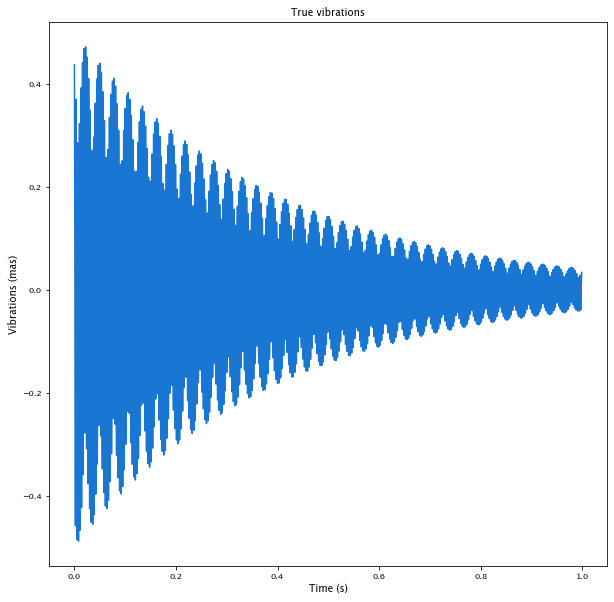

In [2]:
params = make_vibe_params(N_vib_app)
vib_amps = np.random.uniform(low=0.1, high=1, size=N_vib_app)  # milliarcseconds
vib_freqs = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_damping = np.random.uniform(low=1e-5, high=1e-2, size=N_vib_app)  # unitless
vib_phase = np.random.uniform(low=0.0, high=2 * np.pi, size=N_vib_app)  # radians
truth = sum([vib_amps[i] * np.cos(2 * np.pi * vib_freqs[i] * times - vib_phase[i])
               * np.exp(-(vib_damping[i]/(1 - vib_damping[i]**2)) * 2 * np.pi * vib_freqs[i] * times) 
               for i in range(N_vib_app)])
plt.figure(figsize=(10,10)) 
plt.plot(times, truth)
plt.xlabel("Time (s)")
plt.ylabel("Vibrations (mas)")
plt.title("True vibrations")

In [3]:
# construct a true AR2 model from these vibration modes

STATE_SIZE = 2*N_vib_max # 'N_vib_max' modes, and because AR2, those modes one timestep ago.
A = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(N_vib_max):
    k = vib_damping[i]
    f = vib_freqs[i]
    w0 = 2 * np.pi * f / np.sqrt(1 - k**2)
    a_1i = 2 *  np.exp(-k * w0 / f_sampling) * np.cos(w0 * np.sqrt(1 - k**2) / f_sampling)
    a_2i = -np.exp(-2 * k * w0 / f_sampling)
    A[2*i][2*i] = a_1i
    A[2*i][2*i+1] = a_2i
    A[2*i+1][2*i] = 1
    
MEASUREMENT_SIZE = 1

H = np.array([1, 0] * N_vib_max)
    
dt = 1 / f_sampling
# start off the state at k = 1
state = np.zeros(STATE_SIZE)
for i in range(N_vib_max):
    a, f, k, p = vib_amps[i], vib_freqs[i], vib_damping[i], vib_phase[i]
    w_d, w_f = 2*np.pi*f*k/np.sqrt(1-k**2), 2*np.pi*f
    state[2*i] = a * np.cos(w_f * dt - p) * np.exp(-w_d * dt)
    state[2*i + 1] = a * np.cos(p)
    
print(state, [truth[1], truth[0]])

[0.02738824 0.43623928] [0.027388240523099308, 0.4362392843635255]


Text(0.5, 1.0, 'AR2 vibrations')

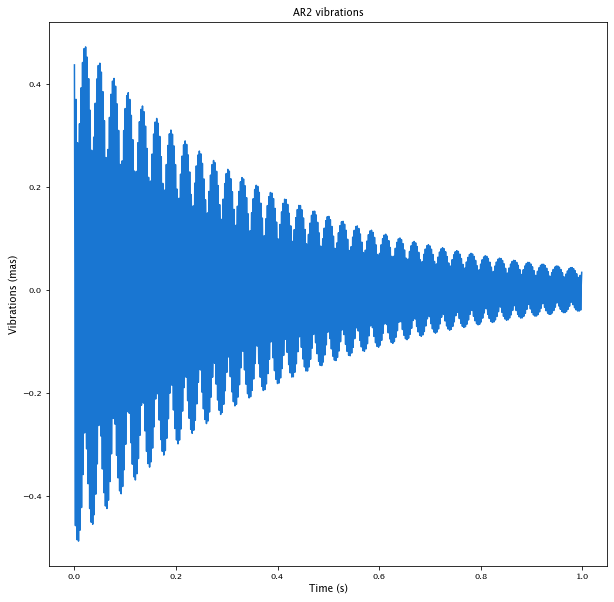

In [4]:
# step 8: simulate without filtering and without applying any control input.

k = 1
ar2 = np.zeros(time_id * f_sampling)
ar2[0] = np.array([0, 1] * N_vib_max).dot(state)
while k < ar2.size:
    ar2[k] = H.dot(state)
    state = A.dot(state)
    k += 1

plt.figure(figsize=(10,10))
plt.plot(times, ar2)
plt.xlabel("Time (s)")
plt.ylabel("Vibrations (mas)")
plt.title("AR2 vibrations")

(-1, 1)

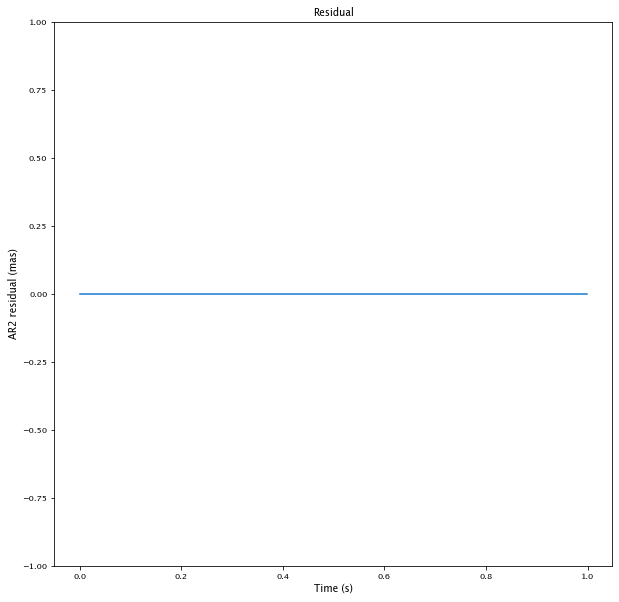

In [6]:
plt.figure(figsize=(10,10))
plt.plot(times, ar2 - truth)
plt.xlabel("Time (s)")
plt.ylabel("AR2 residual (mas)")
plt.title("Residual")
plt.ylim(-1, 1)